In [1]:
import os
import glob
from collections import Counter
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev
import xclim as xc
import numpy as np
import cartopy.crs as ccrs
import cmocean

from unseen import fileio
from unseen import indices

In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
rx14day_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_AGCD-CSIRO_r005_1900-2022_annual_hydro-tas.zarr.zip"
region_name = "hydro-tas"
nino_file = "/g/data/xv83/dbi599/hydrotas/data/nino34-anomaly_HadISST_1870-2022_base-1981-2010.nc"

In [4]:
assert os.path.isfile(rx14day_file), "Must provide an rx14day file (papermill option -p rx14day_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a Nino 3.4 file (papermill option -p nino_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

#### Analyse and plot Rx14day data

In [5]:
ds_rx14day = fileio.open_dataset(rx14day_file)
ds_rx14day = ds_rx14day.dropna('time')

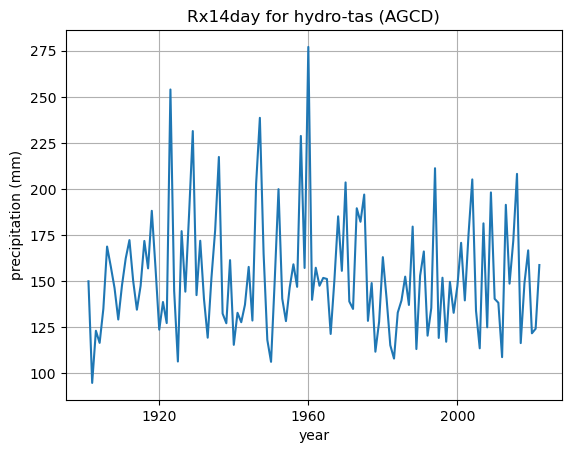

In [9]:
ds_rx14day['pr'].plot()
plt.title(f'Rx14day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.grid()
plt.savefig(
    f'/g/data/xv83/dbi599/hydrotas/figures/Rx14day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [10]:
years = ds_rx14day['time'].dt.year.values
df_rx14day = pd.DataFrame(index=years)
df_rx14day['pr'] = ds_rx14day['pr'].values
df_rx14day['event_time'] = ds_rx14day['event_time'].values

In [11]:
df_rx14day

,pr,event_time
1901,149.938751,1901-09-08
1902,94.808281,1902-06-21
1903,123.113174,1903-07-14
1904,116.524132,1904-06-21
1905,135.024048,1905-02-12
...,...,...
2018,148.899933,2018-07-31
2019,166.724579,2019-07-24
2020,121.734184,2020-10-17
2021,124.216209,2021-08-02


In [12]:
ranked_events = df_rx14day.sort_values(['pr'], ascending=False)
ranked_events.head(n=10)

,pr,event_time
1960,277.080048,1960-04-28
1923,253.982620,1923-05-24
1947,238.617615,1947-06-24
1929,231.435760,1929-04-14
1958,228.780991,1958-05-29
1936,217.387497,1936-08-25
1994,211.277740,1994-05-28
2016,208.212509,2016-06-18
2004,205.203201,2004-07-07
1970,203.572586,1970-08-29


In [13]:
rx14day_max = df_rx14day['pr'].values.max()
print(rx14day_max)

277.08005


In [14]:
event_months = [int(date[5:7]) for date in ds_rx14day['event_time'].values]
event_years = [int(date[0:4]) for date in ds_rx14day['event_time'].values]

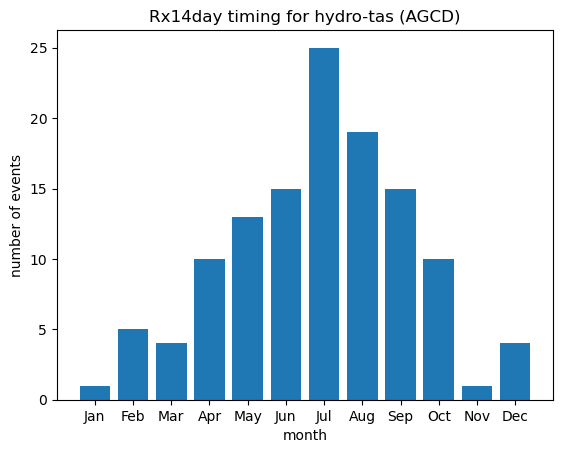

In [15]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx14day timing for {region_name} (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.savefig(
    f'/g/data/xv83/dbi599/hydrotas/figures/Rx14day_timing_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [16]:
nino34_ds = xr.open_dataset(nino_file)

In [17]:
event_nino34 = []
for month, year in zip(event_months, event_years):
    value = nino34_ds['sst'][(nino34_ds['time'].dt.month == month) & (nino34_ds['time'].dt.year == year)].values[0]
    event_nino34.append(value)
event_nino34 = np.array(event_nino34)

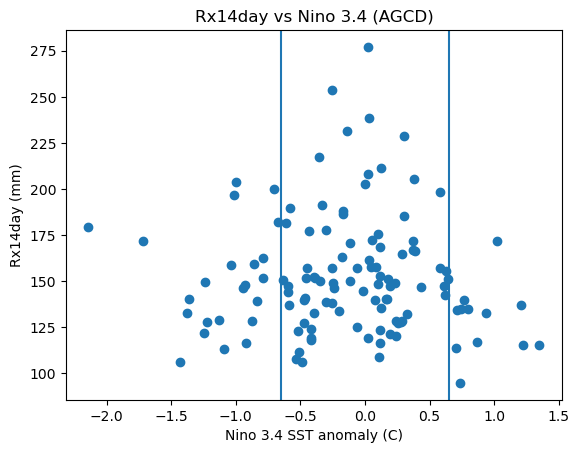

In [19]:
plt.scatter(event_nino34, ds_rx14day['pr'].values)
plt.title(f'Rx14day vs Nino 3.4 (AGCD)')
plt.ylabel('Rx14day (mm)')
plt.xlabel('Nino 3.4 SST anomaly (C)')
plt.axvline(0.65)
plt.axvline(-0.65)
plt.savefig(
    f'/g/data/xv83/dbi599/hydrotas/figures/Rx14day_ENSO_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [20]:
def gev_analysis(ds, event, region, savefig=False):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev_shape, gev_loc, gev_scale = indices.fit_gev(ds.values)
    print(f'Shape parameter: {gev_shape:.2f}')
    print(f'Location parameter: {gev_loc:.2f}')
    print(f'Scale parameter: {gev_scale:.2f}')

    fig, ax = plt.subplots(figsize=[10, 8])
    gev_xvals = np.arange(0, 700)
    ds.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Rx14day for {region} (AGCD)')
    if savefig:
        plt.savefig(
            f'/g/data/xv83/dbi599/hydrotas/figures/Rx14day_histogram_AGCD_{region}.png',
            bbox_inches='tight',
            facecolor='white',
            dpi=dpi
        )
    plt.show()
    
    event_probability = gev.sf(event, gev_shape, loc=gev_loc, scale=gev_scale)
    event_return_period = 1. / event_probability
    event_percentile = (1 - event_probability) * 100
    print(f'{event_return_period:.0f} year return period\n')
    print(f'{event_percentile:.2f}% percentile')

Shape parameter: -0.03
Location parameter: 138.10
Scale parameter: 24.29


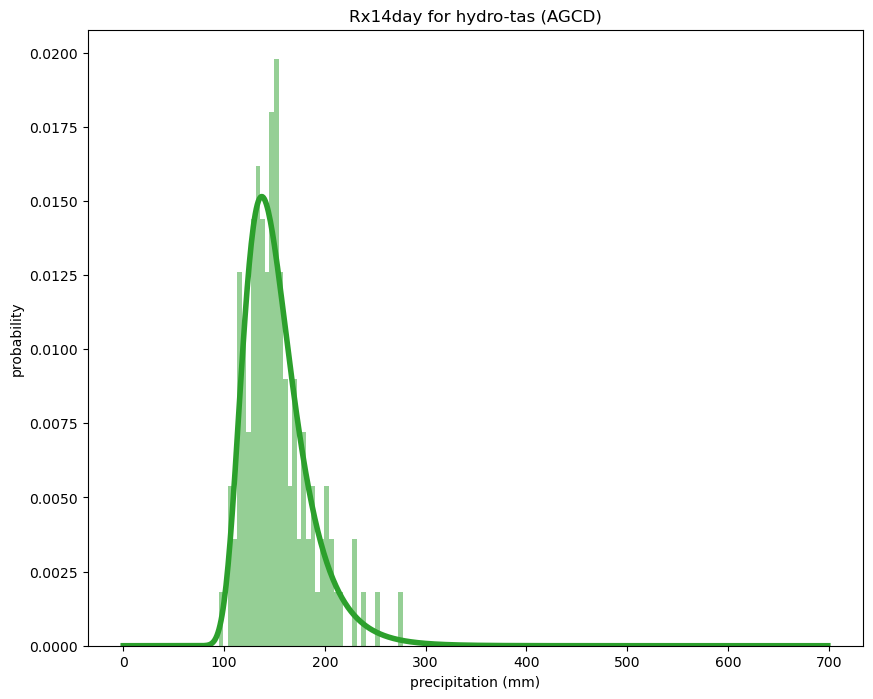

200 year return period

99.50% percentile


In [21]:
gev_analysis(df_rx14day['pr'], rx14day_max, region_name, savefig=True)

#### Meteorology of the most extreme events

### 14-day aggregates

In [23]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    #plt.savefig(
    #    f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
    #    bbox_inches='tight',
    #    facecolor='white',
    #    dpi=300
    #)
    plt.show()

In [24]:
z500_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/zg500/zg500_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
z500_files.sort()

pr_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
pr_files.sort()

psl_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/psl/psl_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
psl_files.sort()

ua300_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/ua300/ua300_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
ua300_files.sort()

In [26]:
pr_files

['/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_200709-200709.nc',
 '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_200710-200710.nc',
 '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_200711-200711.nc',
 '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_200712-200712.nc',
 '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v

In [25]:
z500_ds = xr.open_mfdataset(z500_files)
pr_ds = xr.open_mfdataset(pr_files)
psl_ds = xr.open_mfdataset(psl_files)
ua300_ds = xr.open_mfdataset(ua300_files)

In [ ]:
for index, row in ranked_events.head(n=5).iterrows():
    end_date = row['event_time']
    if int(end_date[0:4]) > 2007:
        rx_value = row['pr']
        print(f'{index} ({end_date}): {rx_value}mm')
        start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
        start_date = start_datetime.strftime("%Y-%m-%d")
        z500_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
        pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
        pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
        psl_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        psl_da = xc.units.convert_units_to(psl_da, 'hPa')
        ua300_da = ua300_ds.sel({'time': slice(start_date, end_date)})['ua300']

        z500_da_mean = z500_da.mean('time', keep_attrs=True)
        pr_da_sum = pr_da.sum('time', keep_attrs=True)
        psl_da_mean = psl_da.mean('time', keep_attrs=True)
        ua300_da_mean = ua300_da.mean('time', keep_attrs=True)    

        plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
        plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
        plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)

### Day-by-day

In [ ]:
def plot_days(contour_var, start_date, end_date):
    """Plot days"""

    pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    
    if contour_var == 'z500':
        contour_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
    elif contour_var == 'psl':
        contour_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        contour_da = xc.units.convert_units_to(contour_da, 'hPa')
    else:
        raise ValueError('Invalid contour variable')
    
    fig = plt.figure(figsize=[20, 18])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 75)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 5)

    plot_order = [1, 4, 7, 10, 13, 2, 5, 8, 11, 14, 3, 6, 9, 12, 15]
    for day in range(15):
        ax = fig.add_subplot(5, 3, plot_order[day], projection=map_proj)
        pr_da.isel({'time': day}).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.rain,
            levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            extend='max',
            cbar_kwargs={'label': 'total precipitation (mm)'},
        )
    
        lines = contour_da.isel({'time': day}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        ax.coastlines()
        ax.gridlines(linestyle='--', draw_labels=True)
        date = str(pr_da.isel({'time': day})['time'].dt.strftime('%d %b').values)
        ax.set_title(date)
        ax.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    plt.suptitle(f'Daily {contour_var} ({contour_da.units})')
#    plt.savefig(
#        f'{contour_var}_days_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [ ]:
plot_days('z500', '2022-02-23', '2022-03-09')

In [ ]:
plot_days('psl', '2022-02-23', '2022-03-09')